In [1]:
from hdbcli import dbapi
import pandas as pd
import seaborn as sns

In [2]:
connection = dbapi.connect('18.202.26.190', 39015, 'SYSTEM', 'Glorp2018!')
connection.isconnected()

True

In [3]:
cursor = connection.cursor()

# Teil 1 - Import t3n data into HANA
## Aufgaben 1/ 2 / 3/ 4

In [ ]:
# data preparation
t3n_data = pd.read_csv('../praktikum1/t3n_data_spider.csv', encoding='utf8')
t3n_df = t3n_data.dropna()
t3n_df = t3n_df.replace('\n','', regex=True)
t3n_df.head()

In [ ]:
# drop table
sql = 'DROP TABLE T3N'
cursor.execute(sql)

In [ ]:
def create_table():
    sql = 'CREATE COLUMN TABLE \"SYSTEM\".\"T3N\" (\"ID\" VARCHAR(500),\"HEADING\" VARCHAR(2000),\"CATEGORY\" VARCHAR(2000),\"TEASER\" VARCHAR(5000),\"TEXT\" CLOB MEMORY THRESHOLD 1000,\"URL\" VARCHAR(2000), PRIMARY KEY (\"ID\"))'
    cursor.execute(sql)

In [ ]:
def get_escaped_string(string):
    return '\'' + str(string) + '\''

In [ ]:
def insert_data():
    for index, row in t3n_df.iterrows():
        sql_insert_datapoint = 'insert into \"SYSTEM\".\"T3N\" (ID, HEADING, CATEGORY, TEASER, TEXT, URL) VALUES (' + get_escaped_string(row['id']) + ', ' + get_escaped_string(row['heading']) +', ' + get_escaped_string(row['category']) + ',' + get_escaped_string(row['teaser']) + ', ' + get_escaped_string(row['text']) + ', ' + get_escaped_string(row['url'])+ ')'
        print(sql_insert_datapoint)
        #print(row['heading'])
        cursor.execute(sql_insert_datapoint)

In [ ]:
create_table()
insert_data()

## Aufgaben 5/ 6

In [ ]:
# CONFIGURATION 'LINGANALYSIS_BASIC'
sql = 'CREATE FULLTEXT INDEX "T3NTEXTIND" ON "SYSTEM"."T3N" ("TEXT") CONFIGURATION \'LINGANALYSIS_BASIC\' ASYNC LANGUAGE DETECTION (\'de\', \'en\') TEXT ANALYSIS ON'
cursor.execute(sql)

In [ ]:
# CONFIGURATION 'LINGANALYSIS_STEMS'
sql = 'CREATE FULLTEXT INDEX "T3NTEXTIND" ON "SYSTEM"."T3N" ("TEXT") CONFIGURATION \'LINGANALYSIS_STEMS\' ASYNC LANGUAGE DETECTION (\'de\', \'en\') TEXT ANALYSIS ON'
cursor.execute(sql)

In [8]:
# CONFIGURATION 'LINGANALYSIS_FULL' 
sql = 'CREATE FULLTEXT INDEX "T3NTEXTIND" ON "SYSTEM"."T3N" ("TEXT") CONFIGURATION \'LINGANALYSIS_FULL\' ASYNC LANGUAGE DETECTION (\'de\', \'en\') TEXT ANALYSIS ON'
cursor.execute(sql)

True

In [7]:
# drop index
sql = 'DROP FULLTEXT INDEX "T3NTEXTIND";'
cursor.execute(sql)

True

# Teil 2 mit SQL
## Aufgabe 1
### SQL-View

In [9]:
# drop SQL-View
sql_drop_view = 'drop view COUNT_NOUNS'
cursor.execute(sql_drop_view)

True

In [10]:
# nouns per document
sql = 'create view COUNT_NOUNS as select ID, TA_TOKEN, count(*) as COUNT from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by ID, TA_TOKEN'
cursor.execute(sql)

True

### Nouns per document

In [25]:
def plot_nouns(nouns_df):
    ax = sns.distplot(nouns_df['count'])
    ax.set(xlabel='#nouns per document')
    ax.set_title('Nouns per document')
    fig = ax.get_figure()
    fig.savefig('plots/nouns_per_document_t3n.png')

#### Using SQL-View

In [26]:
# nouns for all documents
cursor.execute('select ID, sum(COUNT) from COUNT_NOUNS group by ID order by sum(COUNT) desc')
nouns_list = cursor.fetchall()
nouns_df = pd.DataFrame(nouns_list)
nouns_df.columns = ['doc', 'count']
nouns_df.head()

,doc,count
0,bee0f018-cf5e-47d9-a9a3-47adaf0d5e49,686
1,c1727277-36b3-4915-8e3a-94dedccedcf5,642
2,fecf50e9-8c52-4298-9a92-b1c0c72ccc1f,641
3,89a2a47b-ca81-4113-91db-2f5f061cea8a,630
4,3c9378a3-7c1e-44a1-9fb8-f3dd4aae8adb,611


/Users/tinz/anaconda3/envs/python_web_mining/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


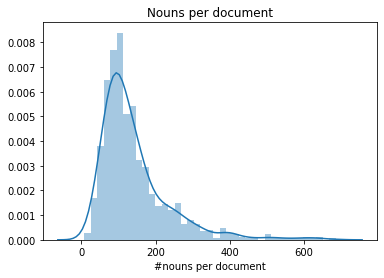

In [27]:
plot_nouns(nouns_df)

In [28]:
# nouns for a specific document
cursor.execute('select * from COUNT_NOUNS')
nouns_list = cursor.fetchall()
nouns_df = pd.DataFrame(nouns_list)
nouns_df.head(20)

,0,1,2
0,0a17ee3f-19e9-47f7-8258-535d491abd27,Seite,1
1,857ea2bf-7aa2-42b6-b755-eda381765413,Einsatz,1
2,655fbf3c-df26-4ce3-a53c-526df0a8d96a,Einige,1
3,14cbb855-ed17-4bbb-985c-70e26364087e,Steinboden,1
4,d2cd153c-f96c-4890-87f2-de40dd7b048c,Markt,1
5,4babb8b4-aeed-4da0-b5a9-0220cc7d094f,Sachen,1
6,660662f7-15a9-4eca-bd0f-f4c249da7c43,Bassreflex,1
7,1b3033a5-37c2-4146-874d-963211111f8f,via,1
8,5a31f902-5f19-4706-946a-8e0ce7eedcb0,Welt,1
9,bb50d3dc-9377-436c-a05f-a17bbaf7e17f,Infografik,1


#### Without SQL-View

In [15]:
# nouns for all documents
cursor.execute('select ID, count(*) from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by ID order by count(*) desc')
nouns_list = cursor.fetchall()
nouns_df = pd.DataFrame(nouns_list)
nouns_df.columns = ['doc', 'count']
nouns_df.head()

,doc,count
0,bee0f018-cf5e-47d9-a9a3-47adaf0d5e49,686
1,c1727277-36b3-4915-8e3a-94dedccedcf5,642
2,fecf50e9-8c52-4298-9a92-b1c0c72ccc1f,641
3,89a2a47b-ca81-4113-91db-2f5f061cea8a,630
4,3c9378a3-7c1e-44a1-9fb8-f3dd4aae8adb,611


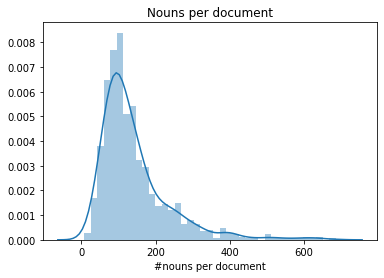

In [16]:
plot_nouns(nouns_df)

In [17]:
# nouns for a specific document
cursor.execute('select ID, TA_TOKEN, count(*) from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by ID, TA_TOKEN')
nouns_list = cursor.fetchall()
nouns_df = pd.DataFrame(nouns_list)
nouns_df.head(20)

,0,1,2
0,0a17ee3f-19e9-47f7-8258-535d491abd27,Seite,1
1,857ea2bf-7aa2-42b6-b755-eda381765413,Einsatz,1
2,14cbb855-ed17-4bbb-985c-70e26364087e,Steinboden,1
3,655fbf3c-df26-4ce3-a53c-526df0a8d96a,Einige,1
4,d2cd153c-f96c-4890-87f2-de40dd7b048c,Markt,1
5,4babb8b4-aeed-4da0-b5a9-0220cc7d094f,Sachen,1
6,660662f7-15a9-4eca-bd0f-f4c249da7c43,Bassreflex,1
7,1b3033a5-37c2-4146-874d-963211111f8f,via,1
8,5a31f902-5f19-4706-946a-8e0ce7eedcb0,Welt,1
9,bb50d3dc-9377-436c-a05f-a17bbaf7e17f,Infografik,1


## Aufgabe 2
### Size of Lexica

In [8]:
cursor.execute('select count(distinct TA_TOKEN) from "$TA_T3NTEXTIND"')
nouns_list = cursor.fetchall()
lexica_size = pd.DataFrame(nouns_list)
lexica_size.columns = ['size']
lexica_size

,size
0,38117


### Size of Lexica without punctuation and stopwords

In [12]:
import nltk as nltk
from nltk.corpus import stopwords

def remove_stopwords(data):
    nltk.download('stopwords')
    german_stopwords = set(stopwords.words('german'))
    data['TOKEN_LOW'] = data['TOKEN'].map(lambda row: str(row).lower())
    filtered = []
    for index, row in data.iterrows():
        if row.TOKEN_LOW not in german_stopwords:
            filtered.append(row.TOKEN_LOW)
    filtered_lexica = pd.DataFrame(filtered)
    filtered_lexica.columns = ['TOKEN']
    return filtered_lexica

In [13]:
cursor.execute('select distinct TA_TOKEN from "$TA_T3NTEXTIND" where TA_TYPE <> \'punctuation\' and TA_TYPE <> \'number\'')
lexica_list = cursor.fetchall()
lexica_df = pd.DataFrame(lexica_list)
lexica_df.columns = ['TOKEN']
lexica_df.size

37569

In [14]:
filtered_lexica = remove_stopwords(lexica_df)
filtered_lexica.size

[nltk_data] Downloading package stopwords to /Users/tinz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


37155

### Mean length of a document

In [17]:
# nouns per document
sql = 'create view COUNT_TOKEN as select ID, count(*) as COUNT from "$TA_T3NTEXTIND" group by ID order by count(*) desc'
cursor.execute(sql)

True

In [16]:
# drop SQL-View
sql_drop_view = 'drop view COUNT_TOKEN'
cursor.execute(sql_drop_view)

True

In [18]:
cursor.execute('select avg(COUNT) from COUNT_TOKEN')
mean_length_doc = cursor.fetchall()
mean_length_doc = pd.DataFrame(mean_length_doc)
mean_length_doc.columns = ['AVERAGE']
mean_length_doc

,AVERAGE
0,536.308853


### Mean length of a sentence

In [19]:
cursor.execute('select AVG(TA_SENTENCE) as AVG_SENTENCE from "$TA_T3NTEXTIND" order by AVG(TA_SENTENCE) desc')
mean_length_sentence = cursor.fetchall()
mean_length_sentence_df = pd.DataFrame(mean_length_sentence)
mean_length_sentence_df_new = mean_length_sentence_df.dropna()
mean_length_sentence_df_new.columns = ['AVERAGE']
mean_length_sentence_df_new.head()

,AVERAGE
0,14.891103


## Aufgabe 3
### Word frequency

In [20]:
cursor.execute('select TA_TOKEN, count(*) from "$TA_T3NTEXTIND" group by TA_TOKEN order by count(*) desc')
words_list = cursor.fetchall()
words_df = pd.DataFrame(words_list)
words_df.columns = ['TOKEN', 'count']
words_df

,word,count
0,",",31716
1,.,18304
2,die,11037
3,der,9988
4,und,9948
...,...,...
38112,Softwareunternehmen,1
38113,Rafaela,1
38114,ragen,1
38115,Softwareseite,1


In [24]:
# with filtered_lexica
cursor.execute('select TA_TOKEN, count(*) from "$TA_T3NTEXTIND" where TA_TYPE <> \'punctuation\' and TA_TYPE <> \'number\' group by TA_TOKEN order by count(*) desc')
lexica_list = cursor.fetchall()
lexica_df = pd.DataFrame(lexica_list)
lexica_df.columns = ['TOKEN', 'count']
lexica_df

,TOKEN,count
0,die,11037
1,der,9988
2,und,9948
3,in,5735
4,das,5452
...,...,...
37564,regional,1
37565,Verzierung,1
37566,Triple,1
37567,Stanley,1


### Frequent and rare words

In [ ]:
# frequent words
cursor.execute('select TA_TOKEN, count(*) from "$TA_T3NTEXTIND" group by TA_TOKEN order by count(*) desc')
words_list = cursor.fetchall()
words_df = pd.DataFrame(words_list)
words_df.columns = ['TA_TOKEN', 'count']
sns.set(rc={'figure.figsize':(27,7)})
sns.barplot(x="TA_TOKEN", y="count", data=words_df.head(20))

In [ ]:
# rare words
words_df.tail(20)

### Restriction to POS-Tags, categories or documents

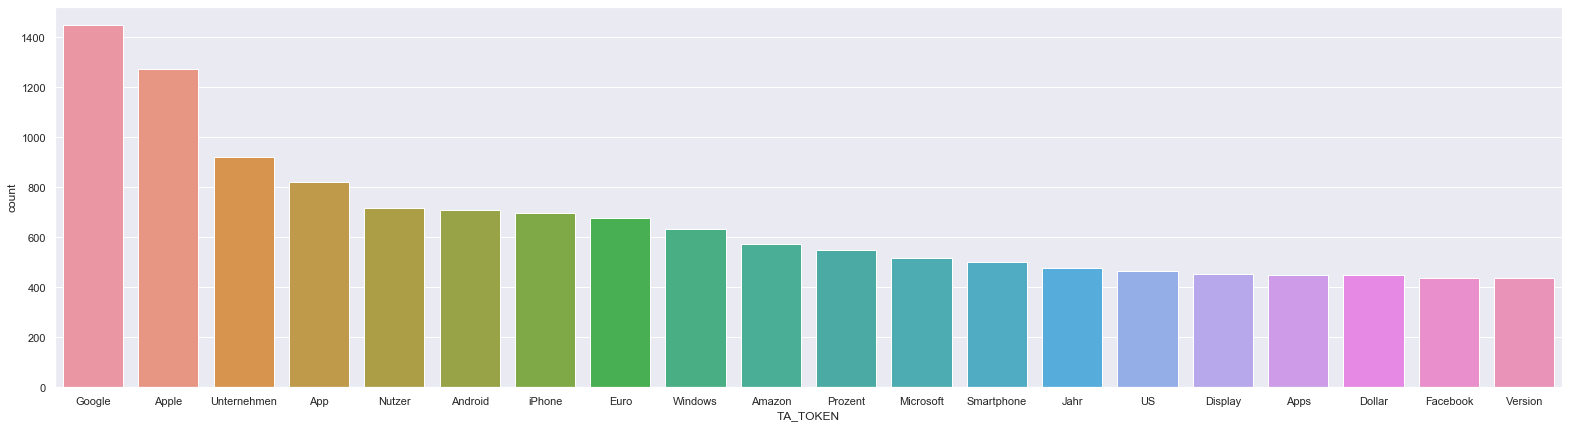

In [35]:
# restriction to nouns
# barplot
cursor.execute('select top 20 TA_TOKEN, count(*) from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by TA_TOKEN order by count(*) desc')
results_words = cursor.fetchall()
results_words_df = pd.DataFrame(results_words)
results_words_df.columns = ['TA_TOKEN', 'count']
sns.set(rc={'figure.figsize':(27,7)})
ax = sns.barplot(x="TA_TOKEN", y="count", data=results_words_df)
fig = ax.get_figure()
fig.savefig('plots/barplot_nouns_t3n.png')

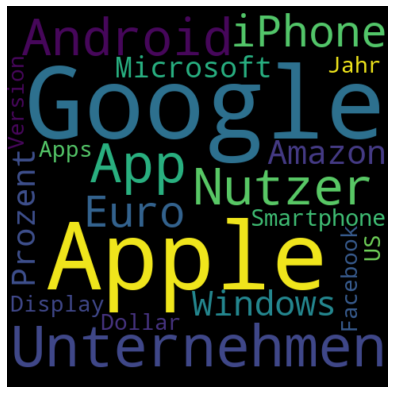

In [59]:
from wordcloud import WordCloud 
import matplotlib.pyplot as plt
tmpDict = {}
cursor.execute('SELECT top 20 TA_TOKEN, count(*) from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by TA_TOKEN order by count(*) desc')
for row in cursor: 
    tmpDict[row[0]]=row[1]
wordcloud = WordCloud(width=480, height=480, margin=0).generate_from_frequencies(tmpDict) 
# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()
wordcloud.to_file('plots/wordcloud_nouns_t3n.png')

In [ ]:
# restriction to category
# frequent words of category Marketing
cursor.execute('select top 20 TA_TOKEN, count(*) from "$TA_T3NTEXTIND", "T3N" where "$TA_T3NTEXTIND".ID = "T3N".ID and "T3N".CATEGORY = \'Marketing\' group by TA_TOKEN order by count(*) desc')
words_list = cursor.fetchall()
results_words_df = pd.DataFrame(words_list)
results_words_df.columns = ['TA_TOKEN', 'count']
sns.set(rc={'figure.figsize':(27,7)})
sns.barplot(x="TA_TOKEN", y="count", data=results_words_df)

## Aufgabe 4

### Ambiguity of words

In [ ]:
cursor.execute('create view POSTAGS as select TA_NORMALIZED as nor, ID as id, TA_TYPE as type, count(*) as count_words from "$TA_T3NTEXTIND" group by TA_NORMALIZED, ID, TA_TYPE having count(*)>1')

In [ ]:
cursor.execute('select NOR, ID, count(NOR) from POSTAGS group by NOR, ID having count(NOR) > 1')
words_list = cursor.fetchall()
words_df = pd.DataFrame(words_list)
df = words_df.dropna()
df.head(30)

## Aufgabe 5

### 1. Statistics

In [ ]:
cursor.execute('SELECT top 10 TA_TOKEN, count(*) from "$TA_T3NTEXTIND" where TA_TYPE=\'noun\' group by TA_TOKEN order by count(*) desc')
words_top_20 = cursor.fetchall()
words_top_20_df = pd.DataFrame(words_top_20)
#words_top_20_df = words_top_20_df.dropna()
words_top_20_df.columns = ['noun', 'count']
words_top_20_df.head(20)

sns.set(rc={'figure.figsize':(17,7)})
sns.set(style="whitegrid")
ax = sns.barplot(x="noun", y="count", data=words_top_20_df)

### 2. Statistics

In [ ]:
cursor.execute('SELECT category from T3N')
category_t3n = cursor.fetchall()
category_t3n_df = pd.DataFrame(category_t3n)
category_t3n_df.columns = ['category']
sns.set(rc={'figure.figsize':(27,7)})
ax = sns.countplot(x="category", data=category_t3n_df)
fig = ax.get_figure()
fig.savefig('plots/categories_countplot_t3n.png')

### 3. Statistics

In [ ]:
# TODO sentiment analysis